# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
import keras.utils as image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

In [2]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=80,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05],  # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
# weights_path = 'path/to/trained/weights/VGG_VOC0712_SSD_300x300_iter_120000.h5'
weights_path = './VGG_coco_SSD_300x300_iter_400000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use fn_output_signature instead


## Get output ssd

In [4]:
import json

parent_path_dir = 'G:/datatset/train2014/train2014/'
j = open('G:/datatset/annotations_trainval2014/annotations/instances_train2014.json')
data = json.load(j)

In [8]:
def output_ssd(img_path):
    input_images = []
    # for file_name in imgs_path:

    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    input_images.append(img)
    input_images = np.array(input_images)
    y_pred = model.predict(input_images,verbose=0)

    confidence_threshold = 0.5
    y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
    r = y_pred_thresh[0].reshape(-1)
    return r


In [6]:
# # Store everything to the disk 
import pickle
import os
file_name_encode_train = 'feature_coco_40k_ssd300_3.pkl'
def dump_encode_train(encoding_train):
    if os.path.exists(file_name_encode_train):
        encode_to_file = pickle.load(open(file_name_encode_train, 'rb'))
        encoding_train = {**encode_to_file, **encoding_train}
        
    with open(file_name_encode_train,"wb") as f:
        pickle.dump(encoding_train,f)

In [14]:
# # Store everything to the disk 
import pickle
import os
file_name_encode_train = 'feature_coco_40k_ssd300_3.pkl'
if os.path.exists(file_name_encode_train):
    encode_to_file = pickle.load(open(file_name_encode_train, 'rb'))
    check = 0
    # print(encode_to_file)
    for d in encode_to_file.keys():
        if len(encode_to_file[d]) > check:
            check = len(encode_to_file[d])
            # print(encode_to_file[d])
            
    # print(len(encode_to_file.keys()))
    print(check)

126


In [12]:
output_ssd_features = {}
batch = 5
inputs = []
id_imgs = []
print(len(data['images']))
for idx,image_info in enumerate(data['images']):
    if idx < 12000: continue
    if idx > 30000: break
    if idx % 1000 == 0:
        print("Encoding in progress time step %d "%idx)
    # inputs.append(parent_path_dir + image_info['file_name'])
    # id_imgs.append(image_info['id'])
    # if len(inputs) == batch :
    #     output = output_ssd(inputs)
    #     for k, id_img in enumerate(id_imgs):
    #         # print(output[k].reshape(-1).shape,id_img)
    #         output_ssd_features[id_img] = output[k].reshape(-1)
    #     inputs = []
    #     id_imgs = []
    # if idx <= 30000 : continue
    output_ssd_features[image_info['id']] = output_ssd(parent_path_dir + image_info['file_name'])
    # print(output_ssd_features[image_info['id']].shape)
    if idx % 3000 == 0:
            dump_encode_train(output_ssd_features)
            output_ssd_features = {}
dump_encode_train(output_ssd_features)

82783
Encoding in progress time step 12000 
Encoding in progress time step 13000 
Encoding in progress time step 14000 
Encoding in progress time step 15000 
Encoding in progress time step 16000 
Encoding in progress time step 17000 
Encoding in progress time step 18000 
Encoding in progress time step 19000 
Encoding in progress time step 20000 
Encoding in progress time step 21000 
Encoding in progress time step 22000 
Encoding in progress time step 23000 
Encoding in progress time step 24000 
Encoding in progress time step 25000 
Encoding in progress time step 26000 
Encoding in progress time step 27000 
Encoding in progress time step 28000 
Encoding in progress time step 29000 
Encoding in progress time step 30000 


## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [21]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = parent_path_dir + "COCO_train2014_000000057870.jpg"

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5272\1220256676.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  orig_images.append(imread(img_path))


## 3. Make predictions

In [22]:
y_pred = model.predict(input_images)

1/1 [==============================] - 0s 418ms/step


`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [25]:
confidence_threshold = 0.0

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0].reshape((-1,)))


Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[ 57.     0.95  46.85 ... 149.36 159.7  188.67]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

In [18]:
# Get label name of dataset coco 
import json
json_raw = open('G:/datatset/annotations_trainval2014/annotations/instances_val2014.json')
load_json = json.load(json_raw)
classes = []
classes.append("background")
for ct in load_json['categories']:
    classes.append(ct['name'])

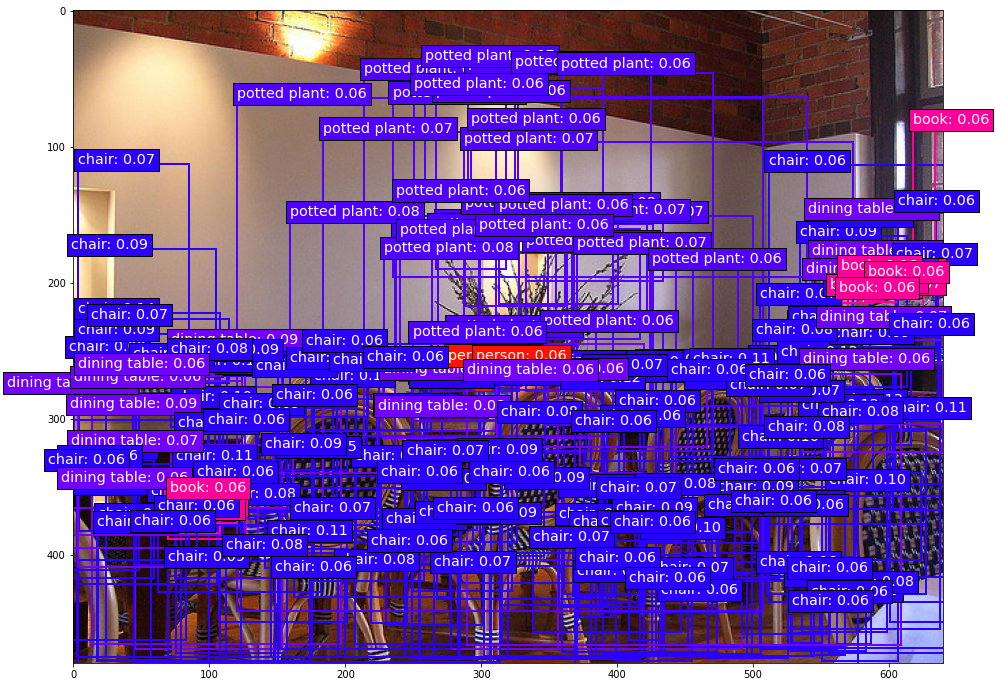

In [19]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 82)).tolist()
# classes = ['background',
#            'aeroplane', 'bicycle', 'bird', 'boat',
#            'bottle', 'bus', 'car', 'cat',
#            'chair', 'cow', 'diningtable', 'dog',
#            'horse', 'motorbike', 'person', 'pottedplant',
#            'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})